# Lab 3: Find SVM parameters by SGD/QP
*Author: Dr. Yiru Zhang*

*Computer Science Departement*

*Ecole Supérieure d'Ingénieur Léonard-de-Vinci*

In this lab session, you will implement SVM, a classification algorithm. Even though many well maintained toolboxes exist (such as scikit learn), you must implement this algorithms from scratch, for a better comprehension of the mathematical behind. You will build the following competences:
1. A better understanding of algorithms SVM.
2. Implementation of SGD as an optimization process.
3. Use `qpsolvers` for quadratic programming solution

This work should be done by group of **TWO students (maximum)**.
Please submit GMM (Lab Session 2) and SVM together as one submission.

## Working on generated data
We create two sets of 80 seperable points `X1` and `X2`, then implement a linear SVM model to classify it. The first set is linarly separable, while the second is not.


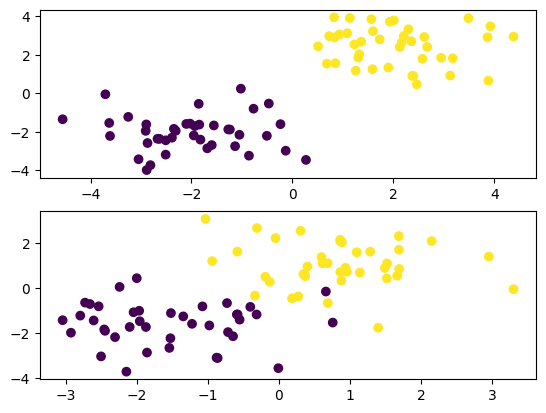

In [58]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
X1 = np.r_[np.random.randn(40, 2) - [2, 2], np.random.randn(40, 2) + [2, 2]]
X2 = np.r_[np.random.randn(40, 2) - [1.5, 1.5], np.random.randn(40, 2) + [1, 1]]
Y = [0] * 40 + [1] * 40
#print(X.shape)
fig, axe = plt.subplots(2)
axe[0].scatter(X1[:, 0], X1[:, 1], c=Y)
axe[1].scatter(X2[:, 0], X2[:, 1], c=Y)
plt.show()

### A. Find parameters by Stochastic Gradient Descent
Given the training data, one general solution is mimizing loss function by gradient descent method.

Recall that a linear Soft SVM is defined as:
$$
\min_{\mathbf{w}, b} \quad \frac{1}{2} {||\mathbf{w}||}^2 +C\sum_{n=1}^N \max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \} := L
$$
where $\frac{1}{2}||\mathbf{w}||^2$ refers to L2-regularizer and C a regularization parameter (See Slide 18 in Lecture 9)

1. Implement the loss function

In [59]:
# Implement hinge loss function L
def loss(X, Y, C, w, b):
    # L2 Regularizer
    regularizer = 0.5 * np.sum(w ** 2)

    # Hinge Loss for each data point
    distances = 1 - Y * (np.dot(X, w) + b)
    distances[distances < 0] = 0  # Max(0, distances)
    hinge_loss = C * np.sum(distances)

    # Total loss
    total_loss = regularizer + hinge_loss
    return total_loss

2. Implement the gradient
By defining the hinge loss, original optimization problem is converted to a new optimization problem without constraint. Therefore, Gradient descent algorithm can be directly applied to solve it.

#### Answer the following questions, then implement

What is the gradient of the Soft SVM loss function $\nabla L$? Give your answer of $\nabla_wL$ and $\nabla_bL$
(The derivatives are conditional, imposed by $\max \{0,1- y(\mathbf{w}^T\mathbf{x} + b) \}$)


#### Your answer here

$$
\nabla_wL = 
\begin{cases} 
    w, & \text{if } 1 - y_i(\mathbf{w}^T\mathbf{x}_i + b) \leq 0 \\
    w - C \cdot y_i \cdot \mathbf{x}_i, & \text{otherwise}
\end{cases}
$$

$$
\nabla_bL = 
\begin{cases} 
    0, & \text{if } 1 - y_i(\mathbf{w}^T\mathbf{x}_i + b) \leq 0 \\
    -C \cdot y_i, & \text{otherwise}
\end{cases}
$$

Then implement:


In [60]:
# Implement the method corresponding to your answer
def derivative_loss(xi, yi, C, w, b):
    """
    Compute the gradient of the loss function with respect to w and b.

    Parameters:
    xi : array-like, shape (n_features,)
        A single input data sample.
    yi : float
        The label of the data sample.
    C : float
        The regularization parameter.
    w : array-like, shape (n_features,)
        The current weights of the SVM.
    b : float
        The current bias of the SVM.

    Returns:
    d_w : array-like, shape (n_features,)
        The gradient of the loss with respect to the weights.
    d_b : float
        The gradient of the loss with respect to the bias.
    """
    condition = yi * (np.dot(w, xi) + b)

    # Check the condition to determine which expression to use for the gradients
    if condition < 1:
        d_w = w - C * yi * xi
        d_b = -C * yi
    else:
        d_w = w
        d_b = 0

    return d_w, d_b



3. implement the learning method

Now you should implement the fitting method, with learning rate $lr$. To remind, the algorithm of SGD is described as follows:
1. Initialize the parameters (w and b, you can initialize them by 1)
2. For every `epoch` in the range of `n_epoch`:
     * iterate on each data sample
     * calculate the derivatives and loss
     * update parameters w and b by `w=w-lr*d_w`, `b=b-lr*d_b`

3. return w and b


In [61]:
# Implement the fitting method with stochastic gradient descent
def fit_SGD(X, Y, C, lr, max_iter):
    w = np.ones(X.shape[1])  # Initialize weights
    b = 1  # Initialize bias

    for epoch in range(max_iter):
        for i in range(len(Y)):
            d_w, d_b = derivative_loss(X[i], Y[i], C, w, b)
            w = w - lr * d_w
            b = b - lr * d_b

    return w, b

4. Implement the prediction method

Prediction is simple. Since SVM is binary classifier, you just need to see which side of the hyper plane does a data sample fall on.

You can use `np.sign()` to get the sign of each element in a matrix.


In [62]:
def predict(X, w, b):
    """
    Return the predicted label of all data in X
    """
    return np.sign(np.dot(X, w) + b)


5. Testing on generated data


We are not using conventional evlauation method for classfication, but a more demonstrative method adaptive to our two-dimentional data: Just plot the hyperplane (the line) separating the two classes, with `w` and `b`



In [63]:
def plot_hyperplane(X, Y, w, b):
    """
    Plot the data points and the separating hyperplane.

    Parameters:
    X : array-like, shape (n_samples, n_features)
        Input data.
    Y : array-like, shape (n_samples,)
        Labels for the data.
    w : array-like, shape (n_features,)
        The weights of the SVM.
    b : float
        The bias of the SVM.
    """
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k')

    # Create a grid to evaluate model
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w) + b

    # Plot decision boundary and margins
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Plot support vectors
    plt.scatter(X[:, 0], X[:, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
    plt.show()




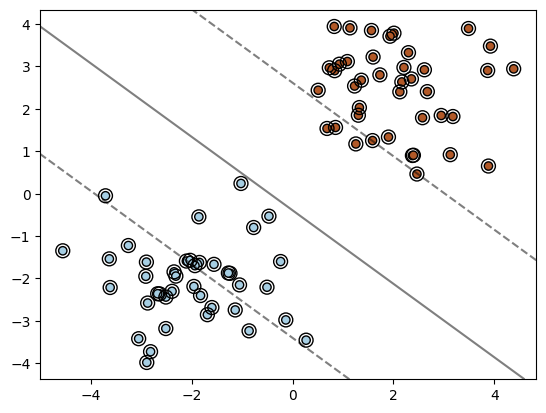

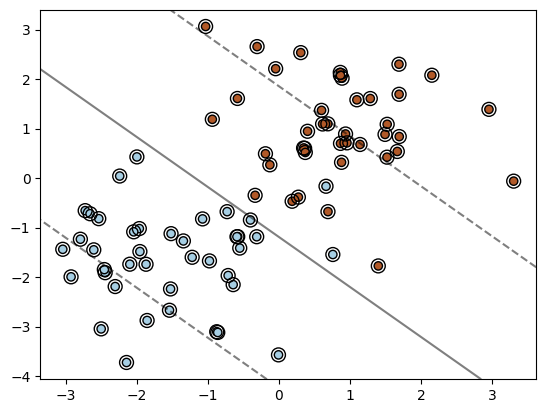

In [64]:
# Convert labels for SVM: from {0, 1} to {-1, 1}
Y = np.array(Y)
Y = np.where(Y == 0, -1, 1)

# Train SVM on the first dataset (linearly separable)
C = 1
lr = 0.01
max_iter = 1000
w1, b1 = fit_SGD(X1, Y, C, lr, max_iter)

# Plot the decision boundary for the first dataset
plot_hyperplane(X1, Y, w1, b1)

# Train SVM on the second dataset (non-linearly separable)
w2, b2 = fit_SGD(X2, Y, C, lr, max_iter)

# Plot the decision boundary for the second dataset
plot_hyperplane(X2, Y, w2, b2)


6. Rewrite your SVM in a python class, with file name `SVM.py`

Just as previous lab session, you need to create a SVM class with parameters `w, b, C, lr, max_iter` as class attributes (with `self`), and methods `_loss()` and  `_derivatie_loss()` as protected methods.
Then, test your code with generated data.

### B. Find Parameters by Quadratic Programming (QP)

During the course, we have learned that

A QP problem is defined as:
$
$\begin{array}{cl}\underset{x}{\operatorname{minimize}} & \frac{1}{2} x^T P x+q^T x \\ \text { subject to } & G x \leq h \\ & A x=b \\ & l b \leq x \leq u b\end{array}$
$



The Lagrangian dual problem of Soft SVM is described by:
<a name="lagrange">
$$
\begin{array}
{cl}\underset{\alpha} {\operatorname{minimize}} & \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N y_i y_j \alpha_i \alpha_j
⟨{x_i},{x_j}⟩ + \sum_{i=1}^N \alpha_i \cr
\text{subject to} \quad& \sum_{i=1}^N y_i \alpha_i =0, \quad 0 \le \alpha_i \le C, \ \forall i=1, \ldots, N
\end{array}
$$
</a>
Attention: in this equation, the variables are $\alpha$. The data $x$ are known values and are used for training process.
The dual function can be therefore rewritten as
$$
\frac{1}{2} \mathbf{𝛂 H 𝛂}^T
 + \mathbf{1}^T \cdot \mathbf{𝛂}
$$
where $\mathbf{H} = y_iy_j⟨{x_i},{x_j}⟩$

Exercise:
1. Assign the correct values to matrix $P, q, G, h, A, b, lb, ub$. Then use qpsolvers to find optimal $\alpha$.

Read [the manuel of qpsovlers](https://pypi.org/project/qpsolvers/) for more utilisation of this toolbox. `qpsolvers` is not provided by Google Colab by default. If you are using Colab, you need to install it by the following command in a code block.
```
!pip install qpsolvers
```



In [65]:
from numpy import matrix
from cvxopt import solvers
import numpy as np

from cvxopt import matrix, solvers
import numpy as np

def solve_alpha(X, Y, C):
    n_samples, n_features = X.shape

    # Ensure Y is a column vector
    Y = Y.reshape(-1, 1) * 1.0
    # Calculate the H matrix for the dual problem
    H = np.dot(Y * X, (Y * X).T)

    # Convert to the format expected by cvxopt
    P = matrix(H)
    q = matrix(-np.ones((n_samples, 1)))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(Y.T)
    b = matrix(np.zeros(1))

    # Solve the QP problem using cvxopt solver
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(solution['x']).flatten()
    return alphas


Once the values of $𝛂$ is found, you can calulate the parameters $\mathbf{w}$ and $\mathbf{b}$ in the SVM.
Calculate $\mathbf{w}$ from equation D1 in Slide 21 of Lecture 9:
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n y_n \mathbf{x}_n
$$
Then, the bias $b$ is calculated by:
$$
b=(1/N)\sum_{i=1}^N(y_i-\sum_{j=1}^Na_jy_jx_j^Tx_i)
$$

2. Implement the fitting method by QP solver `fit_QP()` in your SVM class.
Then test your code with generated data. You can also integrate this method in the SVM class.

In [66]:
def fit_QP(X, Y, C):
    alphas = solve_alpha(X, Y, C)
    sv = (alphas > 1e-5).flatten()
    w = np.dot((alphas[sv] * Y[sv]).T, X[sv]).reshape(-1, 1)
    b = np.mean(Y[sv] - np.dot(X[sv], w))
    return w, b


3. Again, plot the fitted hyperplane with the data, with learned `w` and `b`.

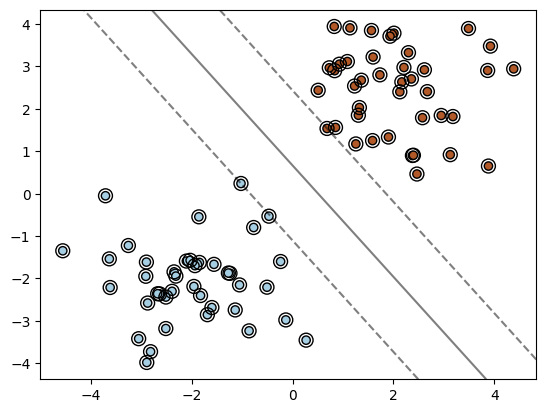

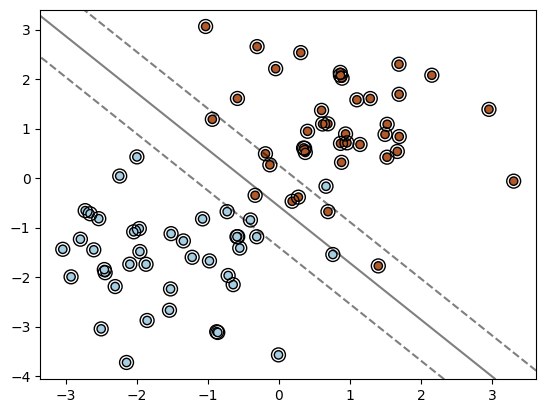

In [67]:
# Train SVM using the QP solver on the first dataset (linearly separable)
w1, b1 = fit_QP(X1, Y, C)

# Plot the decision boundary for the first dataset
plot_hyperplane(X1, Y, w1, b1)

# Train SVM using the QP solver on the second dataset (non-linearly separable)
w2, b2 = fit_QP(X2, Y, C)

# Plot the decision boundary for the second dataset
plot_hyperplane(X2, Y, w2, b2)



## C. SVM with RBF kernel (Optional)

As explained in the lecture, you can implement kernel function to transform the data points into a highier dimentional space, to make the non-separable data separable (linearly). The transformation is simple. Instead of calculating the inner product ($k(x_i,x_j)=⟨{x_i},{x_j}⟩$) in [the Lagrange Dual function](#lagrange), you should apply a transformation
$$
k(x_i,x_j) = exp(\gamma ||x_i-x_j||^2)
$$
where $exp(⋅)$ is an exponential function, $\gamma$ a hyperparameter defined by the user, and $||⋅||^2$ the L2 norm.


In [68]:
def RBF(X, gamma):
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = np.exp(-gamma * np.linalg.norm(X[i] - X[j])**2)
    return K

In [69]:
def solve_alpha_rbf(X, Y, C, gamma):
    n_samples, n_features = X.shape

    # Ensure Y is a column vector
    Y = Y.reshape(-1, 1) * 1.0

    # Calculate the RBF kernel matrix
    K = RBF(X, gamma)

    # The H matrix for the dual problem using the RBF kernel
    H = np.multiply(Y * Y.T, K)

    # Convert to the format expected by cvxopt
    P = matrix(H)
    q = matrix(-np.ones((n_samples, 1)))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(Y.T)
    b = matrix(np.zeros(1))

    # Solve the QP problem using cvxopt solver
    solvers.options['show_progress'] = False 
    solution = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(solution['x']).flatten()
    return alphas


Test your code with ensercled data samples, generated as follows.

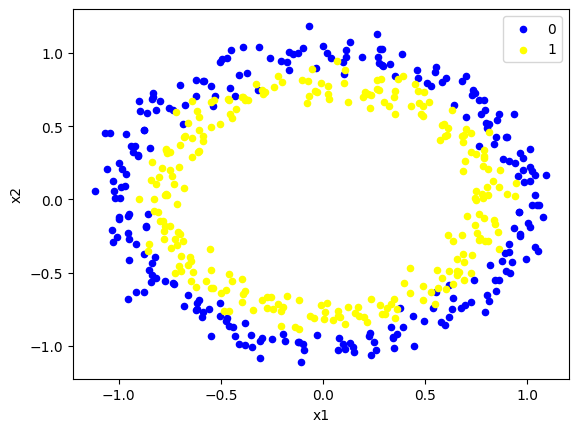

In [70]:
import pandas as pd
from sklearn.datasets import make_circles
X_circle, y_circle = make_circles(n_samples=500, noise=0.06, random_state=42)
df = pd.DataFrame(dict(x1=X_circle[:, 0], x2=X_circle[:, 1], y=y_circle))
colors = {0:'blue', 1:'yellow'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()


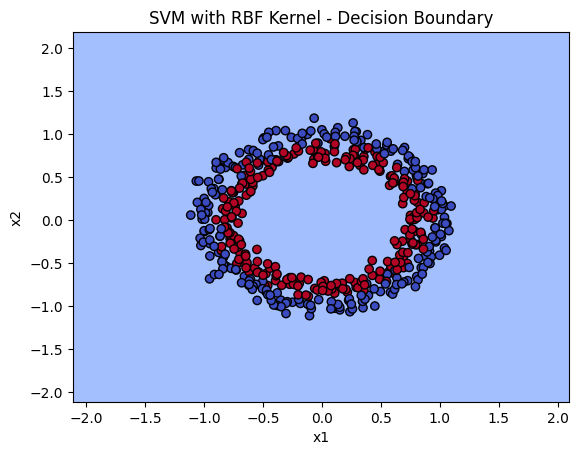

In [71]:
def plot_decision_boundary_rbf(X, Y, alphas, sv, sv_y, b, gamma):
    # Create a grid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Evaluate decision function for each point in the grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros(grid.shape[0])
    for i in range(grid.shape[0]):
        val = 0
        for alpha, sv_x, sv_y_value in zip(alphas, sv, sv_y):
            if alpha > 1e-5:  # Check if it's a support vector
                val += alpha * sv_y_value * np.exp(-gamma * np.linalg.norm(sv_x - grid[i])**2)
        Z[i] = val + b

    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title("SVM with RBF Kernel - Decision Boundary")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

gamma = 0.5
C = 1
alphas = solve_alpha_rbf(X_circle, y_circle, C, gamma)

# Get indices of support vectors
sv_indices = np.where(alphas > 1e-5)[0]
sv_alphas = alphas[sv_indices]
sv_X = X_circle[sv_indices]
sv_y = y_circle[sv_indices]

# Calculate b (bias)
b = np.mean(sv_y - np.sum(sv_alphas * sv_y * RBF(sv_X, gamma), axis=1))

plot_decision_boundary_rbf(X_circle, y_circle, sv_alphas, sv_X, sv_y, b, gamma)

